### Workflow with Orchestration

Implements the following design pattern:
* https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker
* in this version the json schema is derived from the pydantic model (using: model_json_schema())
* all nodes are derived from agent_base_node, therefore supporting integration with APM

In [1]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

from config_reader import ConfigReader
from utils import get_console_logger

# added to integrate with APM
from agent_base_node import BaseAgentNode

# we're using py-zipkin for the integration
from py_zipkin import Encoding
from py_zipkin.zipkin import zipkin_span
from transport import http_transport

In [2]:
#
# Configs and logging
#
# tracing to APM can be disabled/enabled configuring enable_tracing in config.toml

logger = get_console_logger()
config = ConfigReader("config.toml")

SERVICE_NAME = "orch_agent01"

# models used in the rest of the code
ROUTER_MODEL_ID = config.find_key("router_model_id")
AD_MODEL_ID = config.find_key("ad_model_id")


#
# Schema for structured output to use in planning
#
class Section(BaseModel):
    """
    section
    """

    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    """
    sections
    """

    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Graph state
class State(TypedDict):
    """
    workflow state
    """

    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    """
    workflow state
    """

    section: Section
    completed_sections: Annotated[list, operator.add]

In [3]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for i, s in enumerate(state["sections"]):
        print(
            f"{i+1} Calling llm for section {s['name']}\nDescription: {s['description']}"
        )

    return [Send("worker", {"section": s}) for s in state["sections"]]

In [4]:
#
# Shows how to use the runnable class
#


class Orchestrator(BaseAgentNode):
    """
    This is the class for the orchestration node.

    It is derived from BaseTracingNode, therefore supports tracing to OCI APM
    Orchestrator has also a json schema as input, in the init method
    """

    def _run_impl(self, state):
        """Orchestrator: generates a plan for the report"""
        llm = self.get_llm_model(
            model_id=ROUTER_MODEL_ID, temperature=0.0, max_tokens=1024
        )
        planner = llm.with_structured_output(self.json_schema)

        # Generate queries
        report_sections = planner.invoke(
            [
                HumanMessage(
                    content=f"""Generate a plan for the report.\n
                    Follow strictly the following JSON SCHEMA: {str(self.json_schema)}
                    Here is the report topic: {state['topic']}
                    """
                ),
            ]
        )

        return {"sections": report_sections["sections"]}


class Worker(BaseAgentNode):
    """
    This is the class for the worker node.

    It is derived from BaseTracingNode, therefore supports tracing to OCI APM
    """

    def _run_impl(self, state):
        """Subclasses must implement this method."""

        # Generate section
        # we're using another model
        llm = self.get_llm_model(model_id=AD_MODEL_ID, temperature=0.1, max_tokens=2048)
        section = llm.invoke(
            [
                SystemMessage(
                    content="""Write a report section following the provided name and description. 
                    Include no preamble for each section. Use markdown formatting."""
                ),
                HumanMessage(
                    content=f"Here is the section name: {state['section']['name']} and description: {state['section']['description']}"
                ),
            ]
        )

        # Write the updated section to completed sections
        return {"completed_sections": [section.content]}


class Synthesizer(BaseAgentNode):
    """
    This is the class for the summary node.

    It is derived from BaseTracingNode, therefore supports tracing to OCI APM
    """

    def _run_impl(self, state):
        """Subclasses must implement this method."""
        # List of completed sections
        completed_sections = state["completed_sections"]

        # Format completed section to str to use as context for final sections
        completed_report_sections = "\n\n---\n\n".join(completed_sections)

        logger.info("Synthesizer completed !")

        return {"final_report": completed_report_sections}

In [5]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# define the nodes (service name is used for tracing calls)
# Augment the LLM with schema for structured output
orchestrator = Orchestrator(SERVICE_NAME, json_schema=Sections.model_json_schema())
worker = Worker(SERVICE_NAME)
synthesizer = Synthesizer(SERVICE_NAME)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("worker", worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["worker"]
)
orchestrator_worker_builder.add_edge("worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

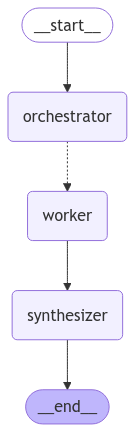

In [6]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [7]:
#
# Helper functions
#
def invoke_agent(agent, user_request: str):
    """
    start the trace
    """
    with zipkin_span(
        service_name=SERVICE_NAME,
        # the name we give to the trace
        span_name="trace_agent01",
        transport_handler=http_transport,
        encoding=Encoding.V2_JSON,
        sample_rate=100,  # this is optional and can be used to set custom sample rates
    ):
        # here we invoke the agent
        state = agent.invoke({"topic": user_request})

    return state


def print_final_report(state):
    display(Markdown(state["final_report"]))

In [8]:
# Invoke
final_state = invoke_agent(orchestrator_worker, "Create a report on AI Agents")
# state = invoke_agent("Create a review article on life and scientific work of Enrico Fermi")

2025-02-27 17:54:13,548 - Calling Orchestrator
2025-02-27 17:54:17,499 - Calling Worker
2025-02-27 17:54:17,500 - Calling Worker
2025-02-27 17:54:17,501 - Calling Worker
2025-02-27 17:54:17,501 - Calling Worker


1 Calling llm for section Introduction
Description: An overview of the report and its purpose.
2 Calling llm for section What are AI Agents?
Description: A definition of AI agents and their role in AI.
3 Calling llm for section Types of AI Agents
Description: A description of the different types of AI agents and their applications.
4 Calling llm for section AI Agents in Practice
Description: Examples of AI agents in real-world applications.
5 Calling llm for section Conclusion
Description: A summary of the report's key findings and insights.


2025-02-27 17:54:17,501 - Calling Worker
2025-02-27 17:54:23,295 - Calling Synthesizer
2025-02-27 17:54:23,296 - Synthesizer completed !


In [9]:
print_final_report(final_state)

### Introduction and Description
#### Overview of the Report
The purpose of this report is to provide a comprehensive analysis of the current situation, highlighting key findings, and presenting recommendations for future improvements. It aims to inform stakeholders about the progress made, challenges faced, and opportunities available.

#### Purpose of the Report
The report serves as a tool for decision-making, offering insights into the strengths and weaknesses of the current system. It identifies areas that require attention, providing a foundation for strategic planning and resource allocation. By presenting a clear and concise overview of the situation, the report enables stakeholders to make informed decisions that drive positive change.

---

### What are AI Agents?
AI agents are autonomous entities that use artificial intelligence to perceive their environment, make decisions, and take actions to achieve specific goals. They are programmed to interact with their environment, adapt to changes, and learn from experiences. AI agents can be categorized into different types, including:
* **Simple Reflex Agents**: React to the current state of the environment without considering future consequences.
* **Model-Based Reflex Agents**: Maintain an internal model of the environment and use it to make decisions.
* **Goal-Based Agents**: Have specific goals and use planning to achieve them.
* **Utility-Based Agents**: Make decisions based on a utility function that estimates the desirability of each action.
AI agents play a crucial role in AI as they enable the development of intelligent systems that can operate autonomously, making decisions and taking actions without human intervention. They are used in various applications, including robotics, expert systems, and virtual assistants.

---

### Types of AI Agents
There are several types of AI agents, each with its own unique characteristics and applications. 
#### 1. Simple Reflex Agents
These agents react to the current state of the environment without considering future consequences. They are commonly used in applications such as:
* Automatic door openers
* Thermostats
* Alarm systems

#### 2. Model-Based Reflex Agents
These agents maintain an internal model of the environment and use it to make decisions. They are commonly used in applications such as:
* Autonomous vehicles
* Robotics
* Smart home devices

#### 3. Goal-Based Agents
These agents have specific goals and use planning and decision-making to achieve them. They are commonly used in applications such as:
* Personal assistants
* Chatbots
* Recommendation systems

#### 4. Utility-Based Agents
These agents make decisions based on a utility function that estimates the desirability of each action. They are commonly used in applications such as:
* Game playing
* Resource allocation
* Scheduling

#### 5. Learning Agents
These agents learn from experience and improve their performance over time. They are commonly used in applications such as:
* Image recognition
* Natural language processing
* Predictive maintenance

Each type of AI agent has its own strengths and weaknesses, and the choice of agent depends on the specific application and requirements.

---

### AI Agents in Practice
#### Examples of AI Agents in Real-World Applications
AI agents are being increasingly used in various real-world applications, transforming the way businesses and organizations operate. Some examples include:
* **Virtual Assistants**: AI-powered virtual assistants, such as Siri, Alexa, and Google Assistant, are being used in smart homes, smartphones, and other devices to perform tasks, provide information, and control other smart devices.
* **Chatbots**: Chatbots are being used in customer service, tech support, and other applications to provide automated support and answer frequently asked questions.
* **Autonomous Vehicles**: AI agents are being used in autonomous vehicles to navigate, make decisions, and control the vehicle's movements.
* **Healthcare**: AI agents are being used in healthcare to diagnose diseases, develop personalized treatment plans, and assist with patient care.
* **Financial Trading**: AI agents are being used in financial trading to analyze market trends, make predictions, and execute trades.
* **Cybersecurity**: AI agents are being used in cybersecurity to detect and respond to threats, identify vulnerabilities, and protect against cyber attacks.
These examples demonstrate the potential of AI agents to transform various industries and applications, and their use is expected to continue growing in the future.

---

### Conclusion
The report's key findings highlight the significance of adopting a multi-faceted approach to addressing the challenges outlined. The insights gathered from the analysis suggest that a combination of strategic planning, innovative solutions, and collaborative efforts is essential for achieving desired outcomes. The main takeaways from the report include:
* The importance of leveraging data-driven decision making to inform policy and practice
* The need for increased investment in research and development to drive innovation
* The potential for technology to enhance efficiency and effectiveness in various sectors
* The critical role of stakeholder engagement and participation in shaping successful outcomes
These findings and insights have important implications for future planning and decision making, and can be used to inform the development of evidence-based strategies and interventions.